# The Ridership Data

How is this ridership data calculated? Does it attempt to account for turnstile hoppers? How is it averaged? Are exceptional days (weekends, holidays) excepted or averaged in?

Answer: taken on non-summer weekdays (presumably different for each station)

There is next train info on ttc website.

Contact presto for better numbers? how to account for cash fares

In [119]:
import urllib.request
from tqdm import tqdm
class subwayStructure(object):
    def __init__(self,linenames=['YUS','BD','SHPD','SCBR']):
        system = urllib.request.urlopen('http://ttc.ca/Subway/getSubwaySystem.action')
        self.info = system.read().decode('utf-8').split('subwayLines":')[1]
        self.lineinfo = {}
        self.stationnames = {}
        self.stationids = {}
        self.stationorder = {}
        for l,line in enumerate(linenames[:2]):
            linedata = self.info.split(line)[1]
            if l+1 < len(linenames):
                linedata = linedata.split(linenames[l+1])[0]
            lineinfo = self.getLineInfo(linedata)
            self.lineinfo[line] = lineinfo
    
    def getProperty(self,key,data,dtype=str):
        prop = data.split('"{0}":'.format(key))[1]
        prop = prop.split(',')[0]
        prop = prop.replace('"','')
        return dtype(prop)
    
    def getStation(self,stationname,stationdata):
        station = {}
        station['name'] = stationname
        station['id'] = self.getProperty('id',stationdata,int)
        station['subwayLine'] = self.getProperty('subwayLine',stationdata,int)
        station['subwayStationOrder'] = self.getProperty('subwayStationOrder',stationdata,int)
        self.stationnames[stationname]=station
        self.stationids[station['id']]=station
        self.stationorder[station['subwayStationOrder']] = station
        return station
    
    def getStations(self,linedata):
        stations = {}
        stationstr = linedata.split('"subwayStations":[{')[1]
        entries = stationstr.split('},{')
        for e,entry in enumerate(entries[:-1]):
            stationname = self.getProperty('name',entry,str)
            stations[stationname] = self.getStation(stationname,entry)    
        return stations

    def getLineInfo(self,linedata):
        lineinfo = {}
        lineinfo['id'] = self.getProperty('id',linedata,int)
        lineinfo['name'] = self.getProperty('name',linedata,str)
        lineinfo['stations'] = self.getStations(linedata)
        return lineinfo
    
    def getTrainInfo(self):
        self.trains = []
        idlist = list(self.stationids.keys())
        for stationid in tqdm(idlist):
            line = self.stationids[stationid]['subwayLine']
            trains = urllib.request.urlopen('http://ttc.ca/Subway/loadNtas.action?subwayLine={0}&stationId={1}&searchCriteria='.format(line,stationid))
            self.trains.append(trains.read().decode('utf-8'))
        
        

In [120]:
struct = subwayStructure()
struct.getTrainInfo()
struct.trains

100%|██████████| 69/69 [00:42<00:00,  1.63it/s]


['{"allLineXStations":null,"allStations":"success","data":null,"defaultDirection":[["VMC1","Southbound<br\\/> To Union","YUS"],["VMC2","Southbound<br\\/> To Union","YUS"]],"limit":3,"ntasData":[{"createDate":"2019-01-29T19:01:16","id":27919409196,"stationDirectionText":"Southbound<br\\/> To Union","stationId":"VMC1","subwayLine":"YUS","systemMessageType":"Normal","timeInt":0.9373523809523809,"timeString":"01.00","trainDestination":"VMC2","trainDestinationStation":"Vaughan Metropolitan Centre","trainDirection":"South","trainId":152,"trainMessage":"Arriving"},{"createDate":"2019-01-29T19:01:16","id":27919409197,"stationDirectionText":"Southbound<br\\/> To Union","stationId":"VMC1","subwayLine":"YUS","systemMessageType":"Normal","timeInt":0.964921568627451,"timeString":"01.00","trainDestination":"VMC2","trainDestinationStation":"Vaughan Metropolitan Centre","trainDirection":"South","trainId":151,"trainMessage":"Arriving"},{"createDate":"2019-01-29T19:01:16","id":27919409198,"stationDirect

In [46]:
struct.lineinfo['SCBR']

'      ","id":4,"name":"Scarborough RT","subwayStations":[{"id":69,"name":"Kennedy","subwayLine":4,"subwayStationOrder":1,"turnback1":null,"turnback2":null},{"id":70,"name":"Lawrence East","subwayLine":4,"subwayStationOrder":2,"turnback1":null,"turnback2":null},{"id":71,"name":"Ellesmere","subwayLine":4,"subwayStationOrder":3,"turnback1":null,"turnback2":null},{"id":72,"name":"Midland","subwayLine":4,"subwayStationOrder":4,"turnback1":null,"turnback2":null},{"id":73,"name":"Scarborough Centre","subwayLine":4,"subwayStationOrder":5,"turnback1":null,"turnback2":null},{"id":74,"name":"McCowan","subwayLine":4,"subwayStationOrder":6,"turnback1":null,"turnback2":null}]}],"subwayStations":null,"turnbacks1":null,"turnbacks2":null,"unservicedStations":null}'

In [1]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup

In [3]:
def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)

In [11]:
raw_html = simple_get('http://ttc.ca/Subway/getSubwaySystem.action')
len(raw_html)

TypeError: object of type 'NoneType' has no len()

In [10]:
raw_html

b'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\r\n<html lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml"> \r\n<head>\r\n\r\n<meta http-equiv="Content-Type" content="text/html; charset=utf-8"/>\r\n<meta name="robots" content="noodp"> \r\n\r\n<meta http-equiv="Content-Language" content="en-ca"/>\r\n<meta property="og:image" content="http://ttc.ca/images/fixedImages/ttc-main-logo.gif" />\r\n\r\n<!--MetaRedirect=false-->\r\n\r\n\r\n<meta name="description" content="The Toronto Transit Commission is the quick, convenient and safe way to get around Toronto. The subway system is linked with buses and streetcars to get you around Toronto on one fare, provided it\'s a one-way trip with no stopovers. You can travel on the TTC every day."/>\r\n\r\n<meta name="keywords" content="Toronto, transit, bus, streetcar, subway, RT, Metropass"/>\r\n\r\n\r\n\r\n<meta name="google-translate-customization" content="508e5e

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# THIS MUST RUN TWICE OR NO ANIMATIONS!
%matplotlib notebook
%matplotlib notebook

In [2]:
# Station names
yus = ['sheppard west','wilson','yorkdale','lawrence west','glencairn','eglinton west','st clair west','dupont','spadina','st george','museum',"queen's park",'st patrick','osgoode','st andrew','union','king','queen','dundas','college','wellesley','bloor','rosedale','summerhill','st clair','davisville','eglinton','lawrence','york mills','sheppard','north york centre','finch']
bd = ['kipling','islington','royal york','old mill','jane','runnymede','high park','keele','dundas west','lansdowne','dufferin','ossington','christie','bathurst','spadina','st george','bay','yonge','sherbourne','castle frank','broadview','chester','pape','donlands','greenwood','coxwell','woodbine','main street','victoria park','warden','kennedy']
danger = ['st clair','lawrence','queen','dundas']
danger_corresp = ['st clair west','lawerence west',"queen's park",'dundas west']
interchange = ['spadina','st george','bloor','yonge'] # bloor-yonge is just one interchange, but it has different names on each line

In [6]:
# Information about time chunking
starttimes = np.array(['06:00','06:15','06:30','06:45','07:00','07:15','07:30','07:45','08:00',
          '08:15','08:30','08:45','09:00','09:15','09:30','09:45','10:00','10:30',
          '11:00','11:30','12:00','12:30','13:00','13:30','14:00','14:30','15:00',
          '15:15','15:30','15:45','16:00','16:15','16:30','16:45','17:00','17:15',
          '17:30','17:45','18:00','18:15','18:30','18:45','19:00','19:30','20:00',
          '20:30','21:00','21:30','22:00','22:30','23:00','23:30','00:00','00:30',
          '01:00'])
starts = np.array([pd.Timestamp('2018-01-01 '+i) for i in starttimes])
starts[52:]+=np.tile(pd.Timedelta('1 day'),3)

endtimes = np.array(['06:14','06:29','06:44','06:59','07:14','07:29','07:44','07:59','08:14',
        '08:29','08:44','08:59','09:14','09:29','09:44','09:59','10:29','10:59',
        '11:29','11:59','12:29','12:59','13:29','13:59','14:29','14:59','15:14',
        '15:29','15:44','15:59','16:14','16:29','16:44','16:59','17:14','17:29',
        '17:44','17:59','18:14','18:29','18:44','18:59','19:29','19:59','20:29',
        '20:59','21:29','21:59','22:29','22:59','23:29','23:59','00:29','00:59',
        '01:29'])

ends = np.array([pd.Timestamp('2018-01-01 '+i) for i in endtimes])
ends[52:]+=np.tile(pd.Timedelta('1 day'),3)

intervals = [(ends[i]-starts[i]).seconds/60 for i in range(len(ends))] 

trainint = {14:3,29:6}
trains = {14:np.floor(14./trainint[14]),29:np.floor(29./trainint[29])}

numbertrains = np.zeros(len(intervals))
traininterval = np.zeros(len(intervals))
for i,interval in enumerate(intervals):
    numbertrains[i] = trains[interval]
    traininterval[i] = trainint[interval]

In [9]:
def read_station_data(stationlist,linenumber):
    stationinfo = pd.DataFrame()
    for station in stationlist:
        stationdata = np.loadtxt('data/{0}-{1}-2017.csv'.format(station,linenumber),delimiter=',',dtype='str')
        stationlabels = np.tile([station],len(starts))
        tostation = stationdata[:,1][:55]
        fromstation = stationdata[:,3][:55]
        totalstation = stationdata[:,5][:55]
        tempdf = pd.DataFrame()
        tempdf['station'] = stationlabels 
        tempdf['start'] = starts
        tempdf['end'] = ends
        tempdf['interval'] = intervals
        tempdf['to'] = tostation.astype(int)
        tempdf['from'] = fromstation.astype(int)
        tempdf['total'] = totalstation.astype(int)
        tempdf['dep_per_min'] = fromstation.astype(int)/intervals
        tempdf['arr_per_train'] = tostation.astype(int)/numbertrains
        tempdf['trains'] = traininterval
        stationinfo = stationinfo.append(tempdf,ignore_index=True)  
    return stationinfo

In [10]:
yusinfo = read_station_data(yus,1)

In [11]:
bdinfo = read_station_data(bd,2)

## Animation

Assume riders arrive at the value 'from' column divided by the time difference. Riders are picked up by trains that run at their scheduled intervals, and a number of riders equal to the value of the 'to' column divided by the number of trains in the interval. For now, assume trains every 3 minutes in the 14 minute increments and every 6 minutes otherwise.

In [18]:
speed

(array([0]),)

In [19]:
timesteps = np.arange(1170)
pops = np.zeros((len(timesteps),len(yus)))
currenttime = starts[0]
train=0
for t,time in enumerate(timesteps):
    for s,station in enumerate(yus):
        # First, add people who have reached the station in the last minute
        speed = np.where((yusinfo['station']==station) & (currenttime >= yusinfo['start']) & (currenttime <= yusinfo['end']))
        pops[t][s] += yusinfo['dep_per_min'][speed[0][0]]
        if train==
    currenttime += pd.Timedelta('1 minute')
        

In [20]:
pops

array([[ 0.07142857,  0.21428571,  0.57142857, ...,  4.42857143,
         1.07142857, 15.21428571],
       [ 0.07142857,  0.21428571,  0.57142857, ...,  4.42857143,
         1.07142857, 15.21428571],
       [ 0.07142857,  0.21428571,  0.57142857, ...,  4.42857143,
         1.07142857, 15.21428571],
       ...,
       [ 1.86206897,  0.65517241,  0.62068966, ...,  6.31034483,
         1.17241379,  6.72413793],
       [ 1.86206897,  0.65517241,  0.62068966, ...,  6.31034483,
         1.17241379,  6.72413793],
       [ 1.86206897,  0.65517241,  0.62068966, ...,  6.31034483,
         1.17241379,  6.72413793]])

<IPython.core.display.Javascript object>


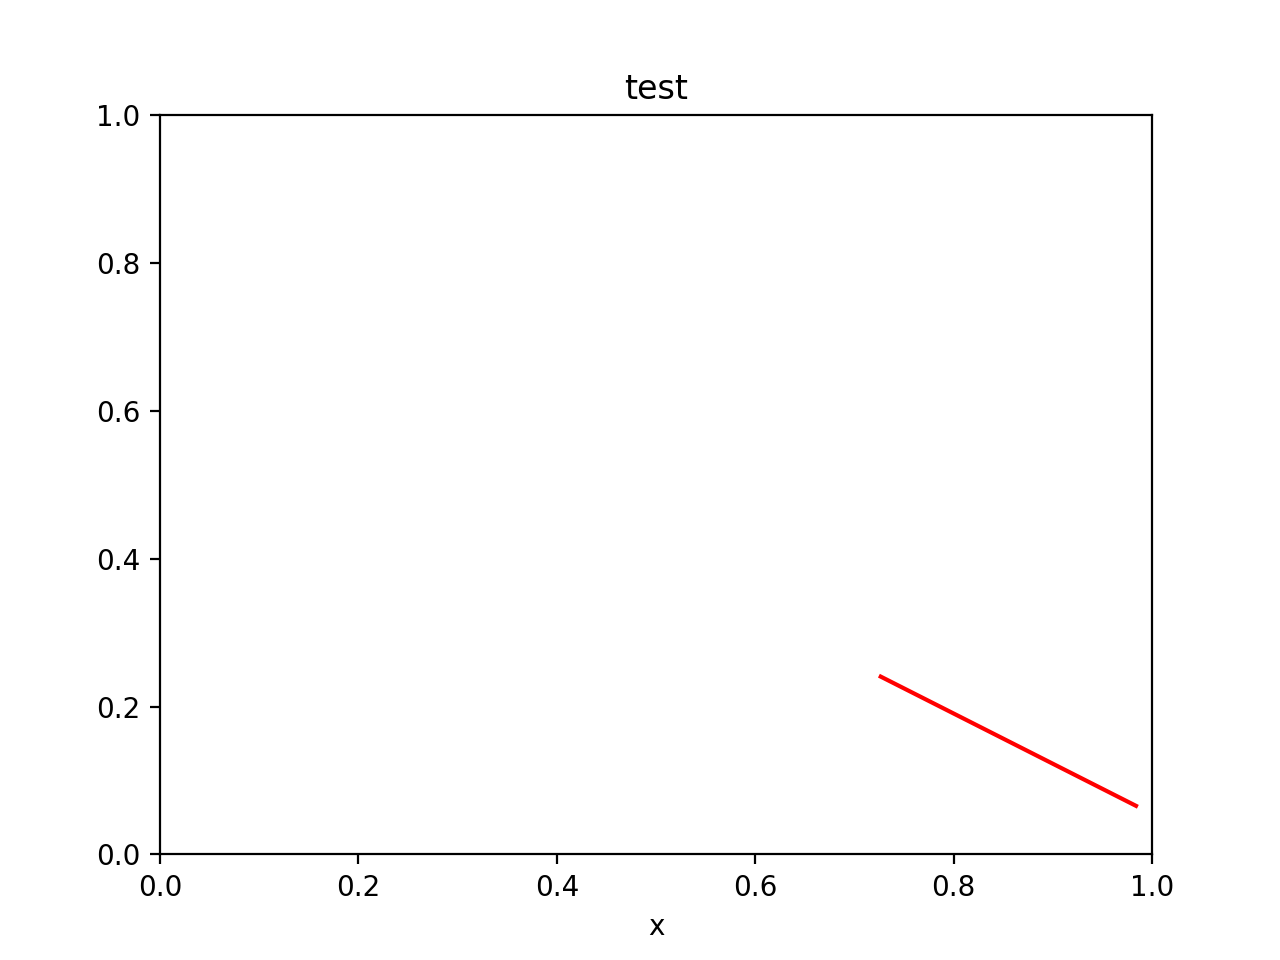

<IPython.core.display.Javascript object>


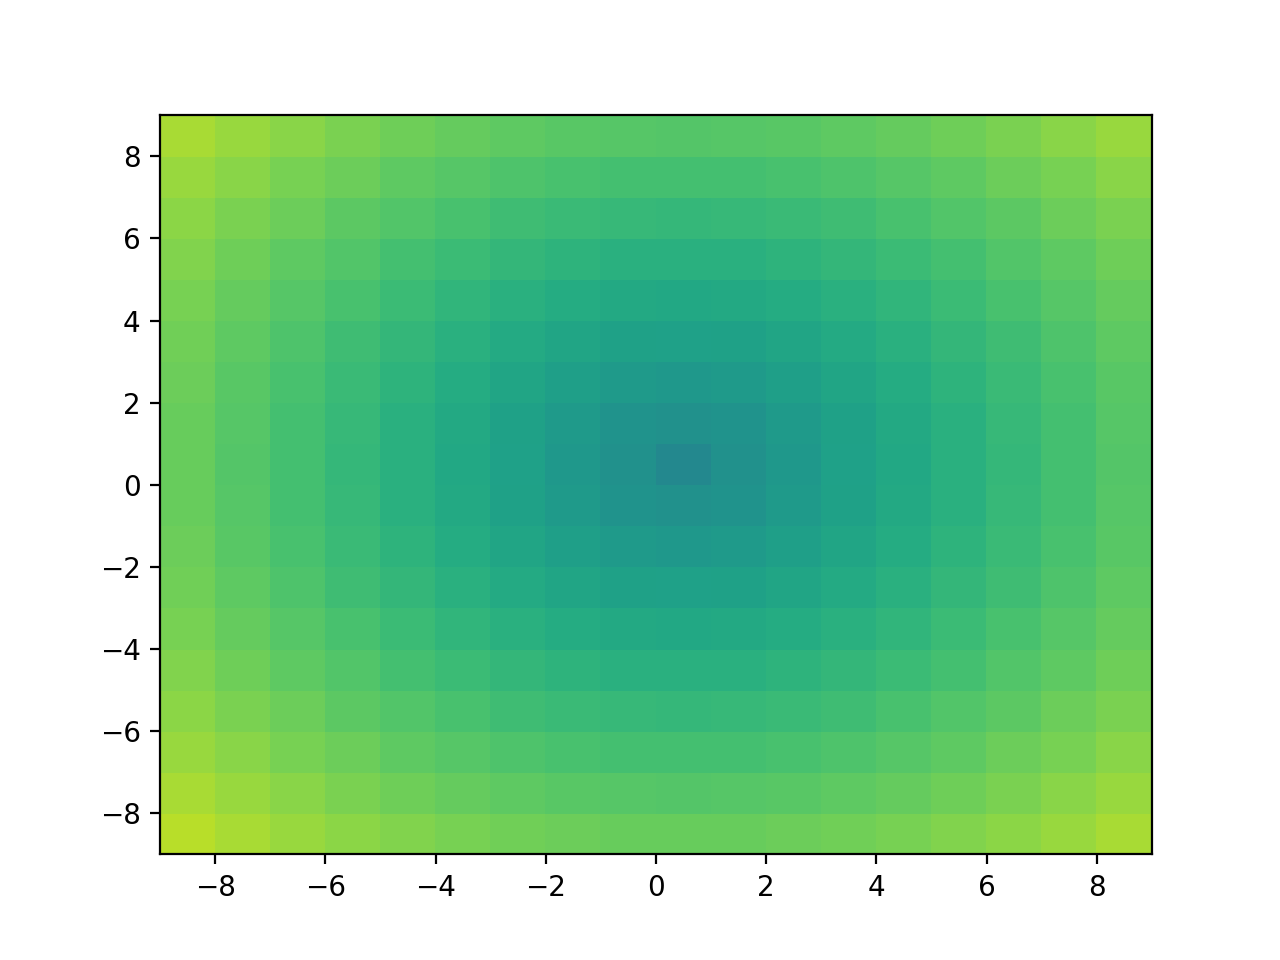

In [14]:
import matplotlib.animation as animation
def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,

fig1 = plt.figure()

data = np.random.rand(2, 25)
l, = plt.plot([], [], 'r-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
                                   interval=50, blit=True)

# To save the animation, use the command: line_ani.save('lines.mp4')

fig2 = plt.figure()

x = np.arange(-9, 10)
y = np.arange(-9, 10).reshape(-1, 1)
base = np.hypot(x, y)
ims = []
for add in np.arange(15):
    ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

im_ani = animation.ArtistAnimation(fig2, ims, interval=50, repeat_delay=3000,
                                   blit=True)
# To save this second animation with some metadata, use the following command:
# im_ani.save('im.mp4', metadata={'artist':'Guido'})

plt.show()

### Map

In [10]:
NS_sep = 1
EW_sep = 1
barheight=2

turn = yus.index('union')
US_posy = np.arange(0,(turn)*NS_sep,NS_sep)[::-1]
US_posx = -EW_sep*np.ones(len(US_posy))
Y_posy = np.arange(0,(len(yus)-turn-1)*NS_sep,NS_sep)
Y_posx = EW_sep*np.ones(len(Y_posy))
NS_posy = np.concatenate((US_posy,-NS_sep*np.ones(1)))
NS_posy = np.concatenate((NS_posy,Y_posy))
NS_posx = np.concatenate((US_posx,np.zeros(1)))
NS_posx = np.concatenate((NS_posx,Y_posx))
# Adjust for two interchanges on west side
NS_posy[0:(yus.index('spadina')+1)] -= NS_sep
NS_posx[0:(yus.index('spadina')+1)] -= EW_sep

# Adjust upwards to make room for bars
NS_posy[0:(yus.index('spadina'))] += (barheight+NS_sep)*NS_sep
NS_posy[(yus.index('bloor'))+1:] += barheight*NS_sep

EW_posx = np.arange(0,len(bd)*EW_sep,EW_sep)
EW_posy = np.zeros(len(EW_posx)) + (NS_posy[yus.index('spadina')])
EW_posx -= EW_posx[bd.index('bay')]

([], <a list of 0 Text yticklabel objects>)

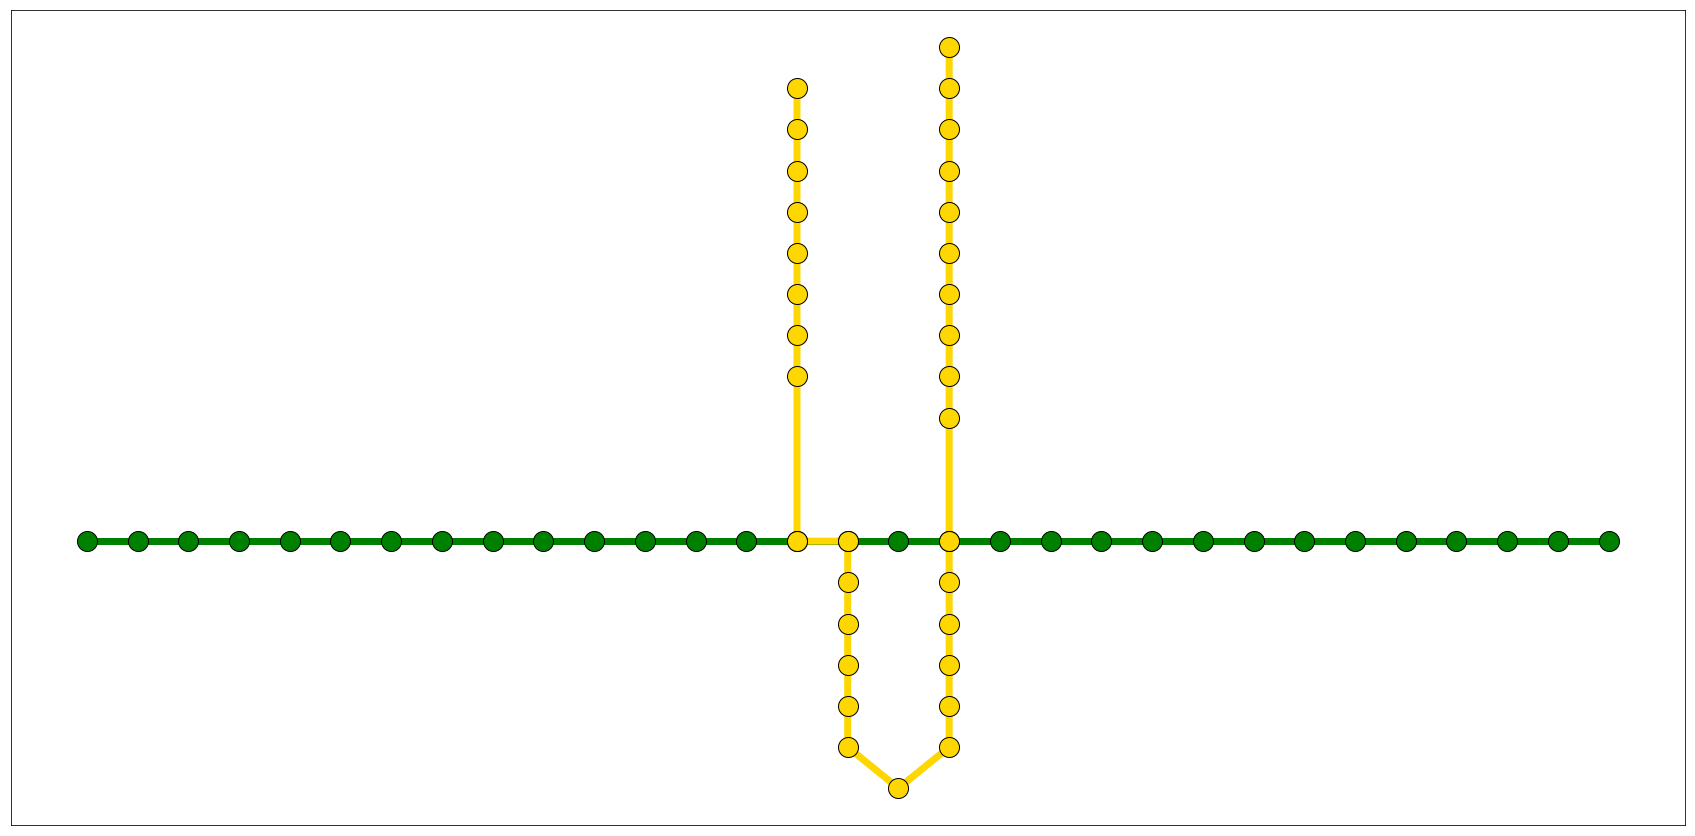

In [11]:
plt.figure(figsize=(30,15))
llw = 7
sms = 20
plt.plot(EW_posx,EW_posy,color='g',lw=llw)
plt.plot(NS_posx,NS_posy,color='gold',lw=llw)
plt.plot(EW_posx,EW_posy,'o',color='g',markersize=sms,markeredgecolor='k')
plt.plot(NS_posx,NS_posy,'o',color='gold',markersize=sms,markeredgecolor='k')
plt.xticks([])
plt.yticks([])

### Yonge-University-Spadina

In [ ]:
yusinfo['']